# Algoritmo di ricerca output massimo - Image Processing

Il programma cerca entro un numero massimo di tentativi (max_tries) la configurazione del sistema che massimizza un singolo output minimizzando gli output rimanenti (sfruttando l'image processing), al termine ne salva la configurazione su file. 

## 1) Import

In [1]:
# Required imports
import sys
username = 'admin' # 'admin' for BO1 lab
sys.path.append('c:/users/'+ username +'/miniconda3/lib/site-packages')
path_to_MyCustomPackage = '../' # relative path to the MyCustomPackage folder 
sys.path.append(path_to_MyCustomPackage)
from MyCustomPackage import mycustommodule
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from matplotlib.patches import Polygon
from matplotlib.ticker import MaxNLocator
from cycler import cycler
from IPython.display import display
from IPython.display import clear_output
import qontrol
import os
import time
import numpy as np
import datetime
import os.path
import math
import logging
import wx

# IP --------

import argparse
import cv2
import imutils
import copy
path_to_selectinwindow = '../MyCustomPackage/opencvdragrect-master' # relative path to the MyCustomPackage folder 
sys.path.append(path_to_selectinwindow)
import selectinwindow

%matplotlib widget

app = wx.App(False) # If you get the error The wx.App object must be created first!, uncomment this line


## 2) Dichiarazione variabili e setup driver

In [2]:
# Variable declarations
max_tries = 1
voltage = 12.0
#channels = [4,8,9,11,15,16,17,19,20,21,22,25,26,27] # the channels connected to the device
#channels = [10,11,12,13,18,20,21,22,23,25]
#np.random.shuffle(channels)

channels = [10,18,20,23,25]
channels.reverse()

channel_PD = 3 # the channel connected to the photodiode
voltage_PD = 0 # the voltage to be set to the photodiode
voltage_start = [0.0 for j in range(len(channels))] # starting voltage values for each channel
voltage_stop = [voltage for j in range(len(channels))] # stopping voltage values for each channel
voltage_step = [0.5 for j in range(len(channels))] # voltage steps for each channel
max_current = 10 # current compliance
max_voltage = 12.0 # voltage compliance
measured_voltage = [[[] for i in range(len(channels))] for j in range(len(channels))] # measured_voltage[channels][channel_under_sweep][measurement]
measured_current = [[[] for i in range(len(channels))] for j in range(len(channels))] # current measurements
PD_voltage = [[] for i in range(len(channels))] # PD voltage measurements
PD_current = [[] for i in range(len(channels))] # PD current measurements
F_move_on = 0 # FLAG : 0 for pausing when a channel sweep is done
F_overlapping_plots = 1 # FLAG : 0 for non overlapping plots, not 0 otherwise 
F_triangular = 0 # FLAG : 0 for ramp sweep, 1 for triangular sweep
now = datetime.datetime.now() # retrieve current date and time (for file name)


# Configuration (Laser and Amplifier)
laser_wavelength = 850
laser_power = 4.93
amplifier_gain = 20
device_model = "Q3_-04_+06"
device = device_model + "_" + str(voltage)  + "V_2sweep"


#Create a custom directory
today = str(datetime. date. today()) 
curr_year = today[:4]; curr_month = today[5:7] 
curr_day = today[8:10]
today = datetime.datetime.now()

if today.hour < 10:
    hour = "0" + str(today.hour)
else:
    hour = today.hour
if today.minute < 10:
    minute = "0" + str(today.minute)
else:
    minute = today.minute   
    
# Directory
directory = curr_year + curr_month + curr_day + str(hour) + str(minute)
  
# Parent Directory path
save_path = "G:/Shared drives/FMPS Archive/Projects/0_QPIXPAD/QPX4/Opt.Meas/" + device_model + "/"
  
# Path
path = os.path.join(save_path, directory)
save_path = path

# Create the directory
os.makedirs(path)
print("Directory '% s' created" % directory)


# Set the right path and file

file_name = "Algoritmo_di_ricerca_output_massimo_" + now.strftime("%d_%m_%Y_%H_%M_%S")+ device + '.txt' 
completeName = os.path.join(save_path, file_name)

# Create an ID an initialize it to a number of zeros equal to the maximum length of the total steps
ID = "1"

if F_triangular == 1:
    total_steps = int(((voltage_stop[0]-voltage_start[0])/voltage_step[0])*len(channels)*max_tries*2)
else:
    total_steps = int(((voltage_stop[0]-voltage_start[0])/voltage_step[0])*len(channels)*max_tries)

for i in range(len(str(total_steps))):
    ID = ID + "0"
    
# ------------------ BUILD THE NEW TABLE FOR SAVING CONFIGURATION ---------------------------------

# System configuration will be a list (A) of lists (B). Each element of the list (A) identifies
# an istantaneous configuration of the system (stored in a list (B)), composed as:
#        [ID, F_triangular, valore_output_imageprocessing, channels[channel_n], I1, V1, ... , In, Vn]

system_configuration = [[] for _ in range(total_steps)]
    

# Build the header of the file as timestamp+configuration+annotation+voltage_parameters+description
timestamp = now.strftime("%d/%m/%Y %H:%M:%S")
configuration = '\n%Laser Wavelength:' + str(laser_wavelength) + '[nm]\n%Laser Power:' +str(laser_power) + '[mW]\n%Amplifier Gain:' \
              + str(amplifier_gain) + '[dB]'
annotation = '\n%TEST ALGORITMO DI RICERCA OUTPUT MASSIMO CON IMAGE PROCESSING. INPUT 1 E OUTPUT 1. DETECTOR INTEGRATI.\n'

voltage_parameters = '%' # voltage_parameters are voltage_start, voltage_stop, voltage_step, triangular
for element in voltage_start:
    voltage_parameters += str(element) + '\t'
voltage_parameters += '\n%'
for element in voltage_stop:
    voltage_parameters += str(element) + '\t'
voltage_parameters += '\n%'
for element in voltage_step:
    voltage_parameters += str(element) + '\t'
voltage_parameters += '\n%' + str(F_triangular) + '\n'

description = '%Swipe sulla tensione con onda sinusoidale su un canale, canali rimanenti a 0 V.Ciascun canale pilota una termoresistenza.' + device
header = '%'+timestamp+configuration+annotation+voltage_parameters+description

# Setup Qontroller
serial_port_name = "COM3" #"COM3" #"/dev/tty.usbserial-FT06QAZ5" # name of the USB Serial Port #//./COM11
q = qontrol.QXOutput(serial_port_name = serial_port_name, response_timeout = 0.1)

# Set the compliances
for channel in range(q.n_chs):
    q.imax[channel] = max_current
    q.vmax[channel] = max_voltage

# Video Debugging
print ("Qontroller '{:}' initialised with firmware {:} and {:} channels".format(q.device_id, q.firmware, q.n_chs) )

"""
# KEITHLEY ADDITION ----------
rm = pyvisa.ResourceManager()
rm.list_resources()


event_type=pyvisa.constants.EventType.service_request
event_mech=pyvisa.constants.EventMechanism.queue
# FROM THE INSTRUMENT WEB-INTERFACE THE NAME IS 
# TCPIP::169.254.207.124::inst0::INSTR
keithley_address_string = 'TCPIP::169.254.207.124::inst0::INSTR' # < ------------- CHECK IT!
inst = rm.open_resource(keithley_address_string)

# Dispolaying Keithley device information
print('Resource name  :', inst.resource_name)
print('Resource info  :',inst.resource_info)
print('Resource class :',inst.resource_class)
print('Resource manuf.:',inst.resource_manufacturer_name)
print(inst.query('*IDN?'))
inst.write('TRAC:CLE') # Clear default buffer defbuffer1
# ---------------------------
"""

# IP -------------

now = datetime.datetime.now()

# Lists to store the bounding box coordinates
top_left_corner=[]
bottom_right_corner=[]
top_left_corner_guess = () 
bottom_right_corner_guess = ()
center = ()
corner = ()
deltax = 0
deltay = 0
click=0
wName = "Select region"


# Take a screenshot of a resolution of screen_resolution and cutting everything that is on the left of xsrc (in pixels) and above ysrc
mycustommodule.take_screenshot(xdest= 0, ydest = 0, xsrc = 960, ysrc = 0, image_name = "starting_image", save_path = save_path, screen_resolution = [960,1080])
        
# ------------------------------------------------------------

#Open the image
image = cv2.imread(save_path + "/starting_image.png")

#convert to Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#OR, with imutils
gray = imutils.resize(gray, width=1080)

# ask if number of rectangles to be catched is already known
rectangles = []

Directory '202205121502' created
Qontroller 'Q8b-0471' initialised with firmware v2.4.1 and 32 channels


## 3) Definizione funzioni

In [3]:
def keithley_voltage_sweep(inst, V_start, V_stop, points, ms_delay = '0,01', current_compliance = '3e-02'): #3e-02 30mA of current compliance by default
    # Make a voltage sweep and measure current both with autorange. Voltage goes from V_start to V_stop with points number of points and 
    # starting after ms_delay ms
    inst.write('*RST')                   #Reset
    inst.write('SENS:FUNC "CURR"')       # Set current measurements
    inst.write('SENS:CURR:RANG:AUTO ON') # Set current range
    inst.write('SENS:CURR:RSEN OFF')     # Set 2wires (4wires off)
    inst.write('SOUR:FUNC VOLT')         # Set voltage source
    inst.write('SOUR:VOLT:RANG:AUTO ON') # Set voltage range:auto
    inst.write('SOUR:VOLT:ILIM '+ current_compliance)       # Set current compliace
    inst.write('SOUR:SWE:VOLT:LIN '+ V_start +', '+ V_stop +', '+ points +', '+ ms_delay) #('SOUR:SWE:VOLT:LIN -2.5, 2.5, 51, 0.01')
    inst.write('OUTPut ON')              # turns the output on
    inst.write(':INIT')                  # Start!
    inst.write('*WAI')                   # wait until all commands are complete
    x=np.array(inst.query_ascii_values('TRAC:DATA? 1, '+ points +', "defbuffer1", SOUR')) # retrieve the voltage readings
    y=np.array(inst.query_ascii_values('TRAC:DATA? 1, '+ points +', "defbuffer1", READ')) # retrieve the current readings
    inst.write('TRAC:CLE') # clear the dafault buffer "defbuffer1"

def keithley_single_measure(inst, sense = 'CURR'): # by default it measures current. To measure voltage, insert 'VOLT'
    inst.write('*RST') # Reset
    inst.write('SENS:'+ sense +':RANG:AUTO ON') # enable autorange
    measurement = inst.query_ascii_values('MEAS:'+ sense +'? READ') # Retrieve one measurement of the specified type
    inst.write('TRAC:CLE') # Clear default buffer defbuffer1
    return measurement

def save_whole_system_configuration(system_configuration, save_path = save_path): # save all the configurations for each step of the algorithm
    
    file_name = "Algoritmo_di_ricerca_output_massimo_image_processing_" + now.strftime("%d_%m_%Y_%H_%M_%S")+ device + '_CONFIGURAZIONE_COMPLETA.txt' 
    completeName = os.path.join(save_path, file_name)
    
    # Build the header of the file as timestamp+configuration+annotation+voltage_parameters+description
    global timestamp,annotation
    configuration = '\n%Laser Wavelength:' + str(laser_wavelength) + '[nm]\n%Laser Power:' +str(laser_power) + '[mW]\n%Amplifier Gain:' \
                  + str(amplifier_gain) + '[dB]'
    #annotation = '\n%TEST ALGORITMO DI RICERCA OUTPUT MASSIMO CON KEITHLEY. INPUT 1 E OUTPUT 2.\n'

    voltage_parameters = '%' # voltage_parameters are voltage_start, voltage_stop, voltage_step, triangular
    for element in voltage_start:
        voltage_parameters += str(element) + '\t'
    voltage_parameters += '\n%'
    for element in voltage_stop:
        voltage_parameters += str(element) + '\t'
    voltage_parameters += '\n%'
    for element in voltage_step:
        voltage_parameters += str(element) + '\t'
    voltage_parameters += '\n%' + str(F_triangular) + '\n'

    description = '%Swipe sulla tensione con onda sinusoidale su un canale, canali rimanenti a 0 V.Ciascun canale pilota una termoresistenza.' + device
    header = '%'+timestamp+configuration+annotation+voltage_parameters+description
    
    # Write the header and the column headers to the file
    meas_file = open(completeName, "a")
    meas_file.write(header)
    meas_file.write("\n%ID\tF_triangular\tKeithley Output\tActive channel")
    for j in range(len(channels)):
        meas_file.write("\tCh" + str(channels[j]) + "[mA]\tCh" + str(channels[j]) + "[V]")
    meas_file.write("\n")
    
    # Write each element of the target configuration list, going newline 
    for k in system_configuration:
        for z in range(len(k)-1):
            meas_file.write(str(k[z]) + '\t')
        meas_file.write(str(k[-1]) + '\n')
    
def save_optimal_configuration(target_configuration, save_path = save_path): # save only the configurations referring to the optimized maxima
    # Set the right path and file
    #save_path = "G:/Shared drives/FMPS Archive/Projects/0_QPIXPAD/QPX4/Opt.Meas/"+ device_model +"/"
    file_name = "Algoritmo_di_ricerca_output_massimo_image_processing_" + now.strftime("%d_%m_%Y_%H_%M_%S")+ device + '.txt' 
    completeName = os.path.join(save_path, file_name)

    # Build the header of the file as timestamp+configuration+annotation+voltage_parameters+description
    global timestamp,annotation
    configuration = '\n%Laser Wavelength:' + str(laser_wavelength) + '[nm]\n%Laser Power:' +str(laser_power) + '[mW]\n%Amplifier Gain:' \
              + str(amplifier_gain) + '[dB]'

    #annotation = '\n%TEST ALGORITMO DI RICERCA OUTPUT MASSIMO KEITHLEY. INPUT 1 E OUTPUT 2.\n'
    termistori = "%" + str(channels) + "\n" #1,4,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,25,26,27\n'
    header = '%'+timestamp+configuration+annotation+termistori+'\n'

    # Write the header and the column headers to the file
    config_file = open(completeName, "a")
    config_file.write(header)
    config_file.write("%ID\tImageProcessing Output")
    for j in range(len(channels)):
        config_file.write("\tCh" + str(channels[j]) + "[V]")
    config_file.write("\n")
    config_file.close()
    config_file = open(completeName, "a") 
            
    # Write each element of the target configuration list, going newline 
    for k in target_configuration:
        for z in range(len(k)):
            if z < 2:
                config_file.write(str(k[z]) + '\t')
            else:
                for w in range(len(k[z])-1):
                    config_file.write(str(k[z][w]) + '\t')
        config_file.write(str(k[-1][-1]) + '\n')
    
    config_file.close()
    
def cost_function(measured_output_vector, expected_output_vector): # for now it is simply the norm of the vector difference
    norm = 0
    for index in range(len(measured_output_vector)): # for each region, compute the norm of the difference between expected and measured
        norm += pow(expected_output_vector[index] - measured_output_vector[index], 2)
    norm = math.sqrt(abs(norm))
    return norm

def norm(vector):
    norm = 0
    for index in range(len(vector)):
        norm += pow(vector[index],2)
    norm = math.sqrt(abs(norm))
    return norm

# IP --------------------------------------
def mousePoints(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x,y)
        
def drawRectangle_old(action, x, y, flags, *userdata):
    # Referencing global variables 
    global top_left_corner, bottom_right_corner, top_left_corner_guess, bottom_right_corner_guess, click
    
    # Mark the top left corner when left mouse button is pressed
    if action == cv2.EVENT_LBUTTONDOWN and click == 0:
        top_left_corner_guess = [x,y]
        click = 1
    
    # When left mouse button is released, mark bottom right corner
    elif action == cv2.EVENT_LBUTTONDOWN and click == 1:
        bottom_right_corner_guess = [x,y]
        click = 0
        
        #     x-->
        #  y  tl-------|
        #  |   |       |
        #  v   |-------br
        top_left_corner = (min(top_left_corner_guess[0],bottom_right_corner_guess[0]),min(top_left_corner_guess[1],bottom_right_corner_guess[1]))
        bottom_right_corner =  (max(top_left_corner_guess[0],bottom_right_corner_guess[0]),max(top_left_corner_guess[1],bottom_right_corner_guess[1]))
        
        cv2.rectangle(gray, top_left_corner, bottom_right_corner, (255,255,255),2, 8)
        cv2.imshow(wName,gray)
        
def drawRectangle(action, x, y, flags, *userdata):
    # Referencing global variables 
    global top_left_corner, bottom_right_corner, center, corner, click, deltax, deltay
    
    # Mark the top left corner when left mouse button is pressed
    if action == cv2.EVENT_LBUTTONDOWN and click == 0:
        center = [x,y]
        click = 1
    
    # When left mouse button is released, mark bottom right corner
    elif action == cv2.EVENT_LBUTTONDOWN and click == 1:
        corner = [x,y]
        click = 0
        
        #     x-->
        #  y  tl-------|
        #  |   |       |
        #  v   |-------br
        
        deltax = abs(center[0]-corner[0])
        deltay = abs(center[1]-corner[1])
        
        top_left_corner = (center[0]-deltax, center[1]-deltay)
        bottom_right_corner =  (center[0]+deltax, center[1]+deltay)
        
        cv2.rectangle(gray, top_left_corner, bottom_right_corner, (255,255,255),2, 8)
        cv2.imshow(wName,gray)
        
def drawRectangle2(action, x, y, flags, *userdata):
    # Referencing global variables 
    global top_left_corner, bottom_right_corner, center, corner, click, deltax, deltay
    
    # Mark the top left corner when left mouse button is pressed
    if action == cv2.EVENT_LBUTTONDOWN:
        center = [x,y]
        
        #     x-->
        #  y  tl-------|
        #  |   |       |
        #  v   |-------br
        
        top_left_corner = (center[0]-deltax, center[1]-deltay)
        bottom_right_corner =  (center[0]+deltax, center[1]+deltay)
        
        cv2.rectangle(gray, top_left_corner, bottom_right_corner, (255,255,255),2, 8)
        cv2.imshow(wName,gray)

# Defining function to draw rectangle
def catch_rectangle_old(gray,wName):

    """
    The function take as input the image the rectangle has to be catched on.
    The First defines the first vertex, the second click defines the opposite vertex.
    The image is closed when the user presses the "q" key
    """

    cv2.imshow(wName, gray)
    click=0
    
    # highgui function called when mouse events occur
    cv2.setMouseCallback(wName, drawRectangle)

    k=0
    
    # Close the window when key q is pressed
    while k!=113:
        # Display the image
        #cv2.imshow(wName, gray)
        k = cv2.waitKey(0)
        
    cv2.destroyAllWindows()
    
    width = bottom_right_corner[0] - top_left_corner[0]
    height = bottom_right_corner[1] - top_left_corner[1]
    
    rectangle = {"top left corner":top_left_corner, "bottom right corner":bottom_right_corner, "width":width, "height":height}
    click = 0
    return rectangle

def catch_rectangle(gray,wName):

    """
    The function take as input the image the rectangle has to be catched on.
    The First defines the first vertex, the second click defines the opposite vertex.
    The image is closed when the user presses the "q" key
    """

    cv2.imshow(wName, gray)
    click=0
    
    # highgui function called when mouse events occur
    cv2.setMouseCallback(wName, drawRectangle)

    k=0
    
    # Close the window when key q is pressed
    while k!=113:
        # Display the image
        #cv2.imshow(wName, gray)
        k = cv2.waitKey(0)
        
    cv2.destroyAllWindows()
    
    rectangle = {"top left corner":top_left_corner, "bottom right corner":bottom_right_corner, "width":2*deltax, "height":2*deltay}
    click = 0
    return rectangle

def catch_rectangle2(gray,wName):

    """
    The function take as input the image the rectangle has to be catched on.
    The First defines the first vertex, the second click defines the opposite vertex.
    The image is closed when the user presses the "q" key
    """

    cv2.imshow(wName, gray)
    click=0
    
    # highgui function called when mouse events occur
    cv2.setMouseCallback(wName, drawRectangle2)

    k=0
    
    # Close the window when key q is pressed
    while k!=113:
        # Display the image
        #cv2.imshow(wName, gray)
        k = cv2.waitKey(0)
        
    cv2.destroyAllWindows()
    
    rectangle = {"top left corner":top_left_corner, "bottom right corner":bottom_right_corner, "width":2*deltax, "height":2*deltay}
    click = 0
    return rectangle

def save_whole_data(data, save_path = save_path): # save all the configurations for each step of the algorithm
    
    global rectangles, timestamp
    
    file_name = "Algoritmo_di_ricerca_output_massimo_image_processing_IMAGE_DATA_" + now.strftime("%d_%m_%Y_%H_%M_%S")+ device + '_CONFIGURAZIONE_COMPLETA.txt' 
    completeName = os.path.join(save_path, file_name)
    
    # Save a file storing all the plot parameters: image name, background array, integral
    meas_file = open(completeName, "a")
    # ID, background_offset, rectangle_integral
    meas_file.write("#ID\tBackground Offset\t")
    for j in range(len(rectangles)):
        meas_file.write("\tRectangle " + str(j))
    meas_file.write("\n")
    #meas_file.write("\n" + str(background_offset))
    for i in data: # plot integral values for each rectangle
        meas_file.write(str(i) + '\n')

    # Close the log file
    meas_file.close()    

## 4) Ricerca del massimo

Select the background box
Insert the number of rectangles to be catched: 4
INSERT THE EXPECTED OUTPUT VECTOR PATTERN [1 or 0 for each output]:
Output 1: 1
Output 2: 0
Output 3: 0
Output 4: 0

PERFORMING TRY N.1 NOW 


DRIVING CHANNEL 25 NOW 


Voltage maximum for channel 25 found: 0.9999 V

Corresponding output from Image Processing: 1.5943863523232586 pixel average value

DRIVING CHANNEL 23 NOW 


Voltage maximum for channel 23 found: 8.0 V

Corresponding output from Image Processing: 1.5705564242520968 pixel average value

DRIVING CHANNEL 20 NOW 


Voltage maximum for channel 20 found: 8.0 V

Corresponding output from Image Processing: 1.5705564242520968 pixel average value

DRIVING CHANNEL 18 NOW 


Voltage maximum for channel 18 found: 8.0 V

Corresponding output from Image Processing: 1.5705564242520968 pixel average value

DRIVING CHANNEL 10 NOW 


Voltage maximum for channel 10 found: 8.0 V

Corresponding output from Image Processing: 1.5705564242520968 pixel average value
[[104

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
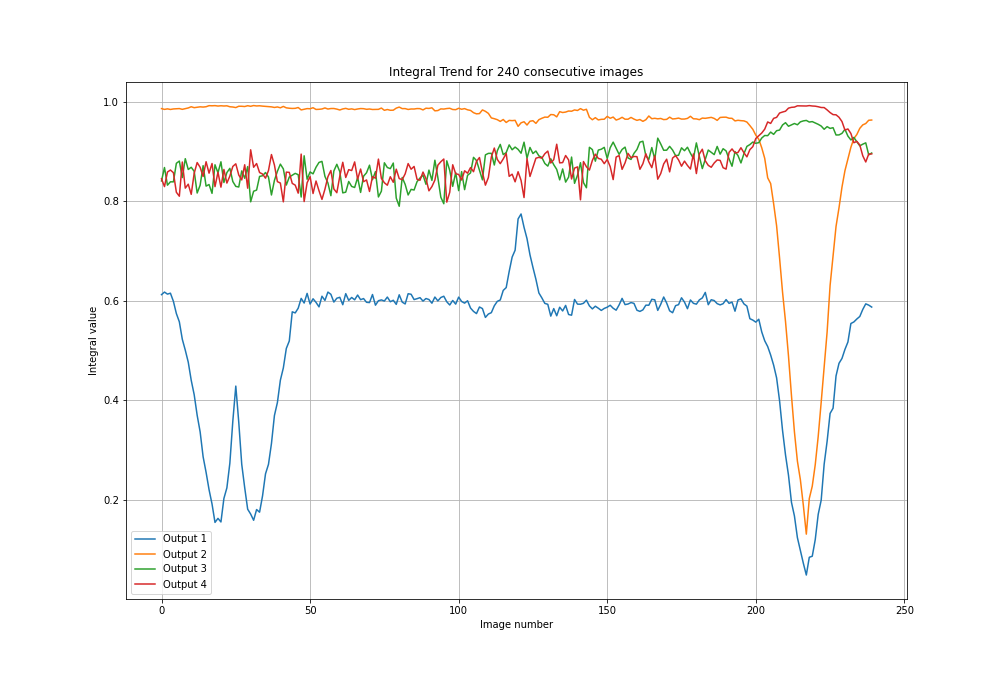


ALL DONE


In [4]:
"""
# Starting Pico with range of 2V, sample interval of 250 microseconds and 5000 total samples
ps = mycustommodule.ps
ctypes = mycustommodule.ctypes
channel_range = ps.PS4000_RANGE['PS4000_5V']
sampleInterval = ctypes.c_int32(250) # in sample units specified by sampleUnits
sampleUnits = ps.PS4000_TIME_UNITS['PS4000_US']
sizeOfOneBuffer = 10 # size of a single buffer
numBuffersToCapture = 1 # totalSamples = sizeOfOneBuffer * numBuffersToCapture
mycustommodule.pico_start(channel_range, sampleInterval = sampleInterval, sampleUnits = sampleUnits, sizeOfOneBuffer = sizeOfOneBuffer, numBuffersToCapture = numBuffersToCapture)
"""

# IP -----------------------------------------
print("Select the background box")
background_box = catch_rectangle(gray,"select background box")

background_offset = np.sum(gray[background_box["top left corner"][1]:background_box["bottom right corner"][1] , \
                                       background_box["top left corner"][0]:background_box["bottom right corner"][0]])/(background_box["width"]*background_box["height"]) 



#fixed_number = input("Is the number of rectangles to be catched fixed? y -> yes    any other key -> No\n")
fixed_number = "y"
if fixed_number == "y":
    number_of_rectangles = int(input("Insert the number of rectangles to be catched: "))
    
    rectangles.append(catch_rectangle(gray,str(0)))
    
    # CALL THAT MANY TIMES THE CATCH_RECTANGLE FUNCTION
    for i in range(number_of_rectangles-1):
        rectangles.append(catch_rectangle2(gray,str(i)))

else: # START CALLING THE CATCH_RECTANGLE FUNCTION UNTIL THE USER STOP IT
    repeat = "y"
    
    rectangles.append(catch_rectangle(gray,str(0)))
    
    while repeat == "y":
        # CALL THE CATCH_RECTANGLE FUNCTION
        rectangles.append(catch_rectangle2(gray, str(i)))
        repeat = input("Do you want to insert catch another rectangle? y -> yes    any other key -> No\n")


integral = [[] for i in range(len(rectangles))]  # integral is a list of elements (list), 
                                                 # each element contains a list of the integrals for each rectangle 
background_array = []                            # This will contain the array of backgrounds

data = []
measured_output_vector = [None for _ in range(len(rectangles))]
##############################################################
expected_output_vector = []

# Creating the expected output vector of the same length of the number of rectangles to be drawn
print("INSERT THE EXPECTED OUTPUT VECTOR PATTERN [1 or 0 for each output]:")
for i in range(len(rectangles)):
    expected_output_vector.append(int(input("Output " + str(i+1) + ": ")))
if len(expected_output_vector) != len(rectangles):
    print("ERROR: OUTPUT VECTOR LENGTH DOES NOT MATCH THE NUMBER OF RECTANGLES.")

##############################################################
                    
# -----------------------------------------------------------------------

target_configuration = [[0, 0.0, [0.0 for j in range(len(channels))]] for i in range(len(channels))] # list of sublist of two elements. First element is output voltage, second element is a list of all driving voltages for each channel
voltage_max = 0.0
max_attuale = 10000.0

current_step = 0
time.sleep(3) # Give the user time to reduce the image to icon

# set all channels to their voltage_start values
for k in range(len(channels)):
    q.v[channels[k]] = float(voltage_start[k])

for i in range(max_tries): # ricerca fino a max_tries e proponi il miglior risultato
    print("\nPERFORMING TRY N.{:} NOW \n" .format(i+1))
    
    #sweep di tensione su ogni canale
    for channel_n in range(len(channels)): # esamina tutti i dof (canali/termoresistenze)
        x = channel_n
        print("\nDRIVING CHANNEL {:} NOW \n" .format(channels[channel_n]))

        #check if we want to generate a triangular sweep or not
        if F_triangular == 1:
            sweep_range = np.concatenate((np.arange(voltage_start[channel_n], voltage_stop[channel_n], voltage_step[channel_n]),\
                            np.arange(voltage_stop[channel_n], voltage_start[channel_n], -voltage_step[channel_n])))
        elif F_triangular == 0:
            sweep_range = np.arange(voltage_start[0], voltage_stop[0]+voltage_step[0], voltage_step[0])
        else:
            print('invalid value for triangular')
            
        for voltage_sweep in sweep_range: 
            q.v[channels[channel_n]] = float(voltage_sweep)
            temp_voltage = q.v[channels[channel_n]]
            
            ###########################################################################################################
            # CALCOLO DEL MEASURED OUTPUT CON IMAGE PROCESSING #
            ###########################################################################################################
            
            # Take a screenshot and open the image -------------------------------------
            mycustommodule.take_screenshot(xdest= 0, ydest = 0, xsrc = 960, ysrc = 0, image_name = str(ID), save_path = save_path, screen_resolution = [960,1080])

            image = cv2.imread(save_path + '/' + str(ID) + '.png')
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            #Resizing the image
            gray = imutils.resize(gray, width=1080)
            output = gray.copy()

            background_offset = np.sum(gray[background_box["top left corner"][1]:background_box["bottom right corner"][1] , \
                                               background_box["top left corner"][0]:background_box["bottom right corner"][0]])/(background_box["width"]*background_box["height"])
            background_array.append(background_offset)

            # Creating a fixed length list for first row (for higher performance)
            new_row = [None for _ in range(len(rectangles)+2)]

            # Populate first part of the new row with: ID, background offset
            new_row[0] = ID
            new_row[1] = background_offset

            for k in range(len(rectangles)):

                # Computing the sum of pixel values inside the selected rectangle and normalizing it by the rectangle area and subtracting the background
                rectangle_integral = np.sum(gray[rectangles[k]["top left corner"][1]:rectangles[k]["bottom right corner"][1] , \
                                               rectangles[k]["top left corner"][0]:rectangles[k]["bottom right corner"][0]]\
                                         )/(rectangles[k]["width"]*rectangles[k]["height"])-background_offset
                integral[k].append(rectangle_integral)

                # Populate remaining part of the new row with: rectangle1, ..., rectanglen
                new_row[k+2] = rectangle_integral
                
                measured_output_vector[k] = rectangle_integral
              
                cv2.rectangle(output, rectangles[k]["top left corner"], rectangles[k]["bottom right corner"], (255, 255, 255), 2) #(source_image, top left corner, bottom right corner, color, thickness)

            measured_output_vector_norm = norm(measured_output_vector)
            # making measured_output_vector having a norm of 1
            for index in range(len(measured_output_vector)):
                measured_output_vector[index] = measured_output_vector[index]/measured_output_vector_norm
                new_row[index+2] = measured_output_vector[index]
                integral[index][-1] = measured_output_vector[index] #############################################
            
            data.append(new_row) #data[current_step] = new_row

            cv2.imshow("Rectangle", output)
            cv2.waitKey(100)  

            # -----------------------------------------------------------    
            
            valore_output_imageprocessing = cost_function(measured_output_vector, expected_output_vector)
            
            if valore_output_imageprocessing < max_attuale: # se trovi un nuovo massimo, salvalo al posto del massimo finora trovato
                voltage_max = q.v[channels[channel_n]]
                max_attuale = valore_output_imageprocessing
                
            # ----- UPDATING THE CONFIGURATION SYSTEM LIST ----------------------
            
            # Creating a fixed length list for first row (for higher performance)
            new_row = [-1 for _ in range((len(channels)*2)+4)]

            # Populate first part of the new row with: ID, flag for triangular sweep, voltage value from pico, active channel
            new_row[0] = int(ID)
            new_row[1] = F_triangular
            new_row[2] = valore_output_imageprocessing
            new_row[3] = channels[channel_n]

            # Populate remaining part of the new row with: I1, V1, ..., In, Vn
            for j in range(len(channels)): # acquire voltage and current for all channels. Then print them on screen and save them on file
                temp_voltage = q.v[channels[j]]
                temp_current = q.i[channels[j]]
                new_row[2*j+4] = temp_current
                new_row[2*j+5] = temp_voltage
                
            system_configuration[current_step] = new_row
            current_step += 1
            
            # ---------------------------------------------------------------------
            ID = int(ID) + 1
            
        q.v[channels[channel_n]] = voltage_max # setta il canale attuale alla tensione corrispondente al suo massimo
        print("\nVoltage maximum for channel {:} found: {:} V" .format(channels[channel_n],voltage_max))
        
        target_configuration[channel_n][0] = int(ID)
        
        target_configuration[channel_n][1] = max_attuale # salva l'output del massimo per il canale attuale
        print("\nCorresponding output from Image Processing: {:} pixel average value" .format(max_attuale))
         
        # storing in target_configuration the entire current configuration (corresponding to the current found maximum)
        for k in range(len(channels)):
            target_configuration[channel_n][2][k] = q.v[channels[k]] # salva per il canale attuale, nella lista delle driving voltages, ciascun driving voltage
        
# Close the Keithley
#inst.write('OUTPut OFF')

print(target_configuration)

# Set the System to last row of target configuration (i.e. the configuration resembling the maximum for the last sweep performed)
print("Setting the system to last row of target configuration")
for k in range(len(target_configuration[-1][2])):
    q.v[channels[k]] = target_configuration[-1][2][k]

save_whole_system_configuration(system_configuration)
save_optimal_configuration(target_configuration)


# IP -------------------------------------

# Save data
save_whole_data(data)

#Plotting the integral ----------------------------

data_figure = plt.figure("Integrals")
data_figure.set_size_inches(14, 9.5, forward=True)
data_plot = data_figure.add_subplot(111)

for i in range(len(integral)): # plot integral values for each rectangle
    data_plot.plot(integral[i], label= "Output " + str(i+1))
data_plot.legend()

data_plot.set_xlabel('Image number')
data_plot.set_ylabel('Integral value')
data_plot.set_title('Integral Trend for ' + str(len(integral[0])) + ' consecutive images')
data_plot.grid(True)
plt.savefig(save_path + "/" + "Output_optimization_plot.png")
plt.show()
# -----------------------------------------------------------


# close all open windows
cv2.destroyAllWindows()
# ---------------------------------------

print("\nALL DONE")

In [ ]:
# Set all channels to zero
q.v[:] = 0
q.i[:] = 0

# Close the communication with the driver
q.close()